# Ridge Regression

## Goal

Given a dataset with continuous inputs and corresponding outputs, the objective is to find a function that matches the two as accurately as possible. This function is usually called the target function.

In the case of a ridge regression, the idea is to modellize the target function as a linear sum of functions (that can be non linear and are generally not). Thus, with f the target function, $\phi_i$ a base function and $w_i$ its weight in the linear sum, we suppose that:
$$f(x) = \sum w_i \phi_i(x)$$

The parameters that must be found are the weights $w_i$ for each base function $\phi_i$. This is done by minimizing the [root mean square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation).

There is a closed solution to this problem given by the following equation $W = (\Phi^T \Phi)^{-1} \Phi^T Y$ with:
- $d$ the number of base functions
- $W = (w_0, ..., w_d)$ the weight vector
- $Y$ the output vector
- $\Phi(X) = (\phi_0(X)^T, \phi_1(X)^T, ..., \phi_d(X)^T)$, $\phi_0(X) = \mathbf{1}$ and $\phi_i(X) = (\phi_i(X_1), ... \phi_i(X_n))$.

If you want more details, I find that the best explanation is the one given in the book [Pattern Recognition and Machine Learning](http://research.microsoft.com/en-us/um/people/cmbishop/PRML/) by C. Bishop.

## Implementation

The following implementation does exactly what is explained above and uses three different types of kernel: 
- linear $f(x) = w_0 + w_1 x$
- polynomial $f(x) = \sum_{i=0}^d w_i x^i$ with d the degree of the polynome. Notice that d = 1 gives the linear kernel
- gaussian $f(x) = \sum w_i \exp(-\frac{x - b_i}{2 \sigma^2})$ with $b_i$ define the location of the base function number $i$ (they are usually taken at random within the dataset) and $\sigma$ a parameter tuning the width of the functions.

The steps are:
- normalization
- building the $\Phi$ matrix
- computing the weights $W$
- plotting the found function and the dataset

In [1]:
# to display plots within the notebook
%matplotlib inline
# to define the size of the plotted images
from pylab import rcParams
rcParams['figure.figsize'] = (15, 10)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numpy.linalg import inv

from fct import normalize_pd

The X matrix correspond to the inputs and the Y matrix to the outputs to predict.

In [2]:
data = pd.read_csv('datasets/data_regression.csv')
X = data['X']
Y = data['Y']

# Normalization
X = np.asmatrix(normalize_pd(X)).T
Y = np.asmatrix(normalize_pd(Y)).T

## Linear regression

Here we have $\Phi(X) = X$. The function we look for has the form $f(x) = ax + b$.

In [3]:
def linear_regression(X, Y):
    # Building the Phi matrix
    Ones = np.ones((X.shape[0], 1))
    phi_X = np.hstack((Ones, X))

    # Calculating the weights
    w = np.dot(np.dot(inv(np.dot(phi_X.T, phi_X)), phi_X.T), Y)
    
    # Predicting the output values
    Y_linear_reg = np.dot(phi_X, w)

    return Y_linear_reg

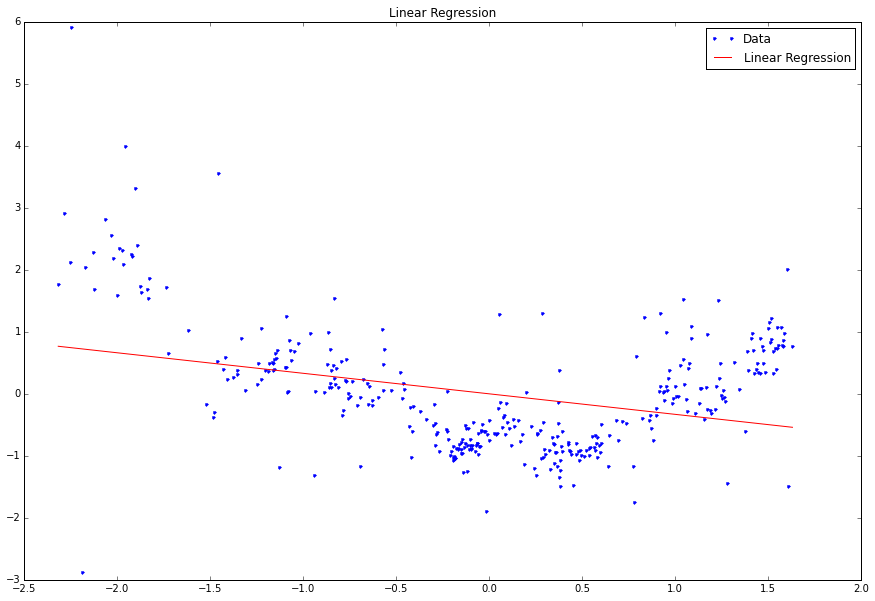

In [4]:
Y_linear_reg = linear_regression(X, Y)

plt.plot(X, Y, '.')
plt.plot(X, Y_linear_reg, 'r')
plt.title('Linear Regression')
plt.legend(['Data', 'Linear Regression'])

The obtained solution does not represent the data very well. It is because the power of representation is too low compared to the target function. This is usually referred to as **underfitting**.

## Polynomial Regression

Now, we approximate the target function by a polynom $f(x) = w_0 + w_1 x + w_2 x^2 + ... + w_d x^d$ with $d$ the degree of the polynom.

We plotted the results obtained with different degrees.

In [5]:
def polynomial_regression(X, Y, degree):
    # Building the Phi matrix
    Ones = np.ones((X.shape[0], 1))
    # Add a column of ones
    phi_X = np.hstack((Ones, X))

    # add a column of X elevated to all the powers from 2 to degree
    for i in range(2, degree + 1):
        # calculate the vector X to the power i and add it to the Phi matrix
        X_power = np.array(X) ** i
        phi_X = np.hstack((phi_X, np.asmatrix(X_power)))

    # Calculating the weights
    w = np.dot(np.dot(inv(np.dot(phi_X.T, phi_X)), phi_X.T), Y)
    
    # Predicting the output values
    Y_poly_reg = np.dot(phi_X, w)

    return Y_poly_reg

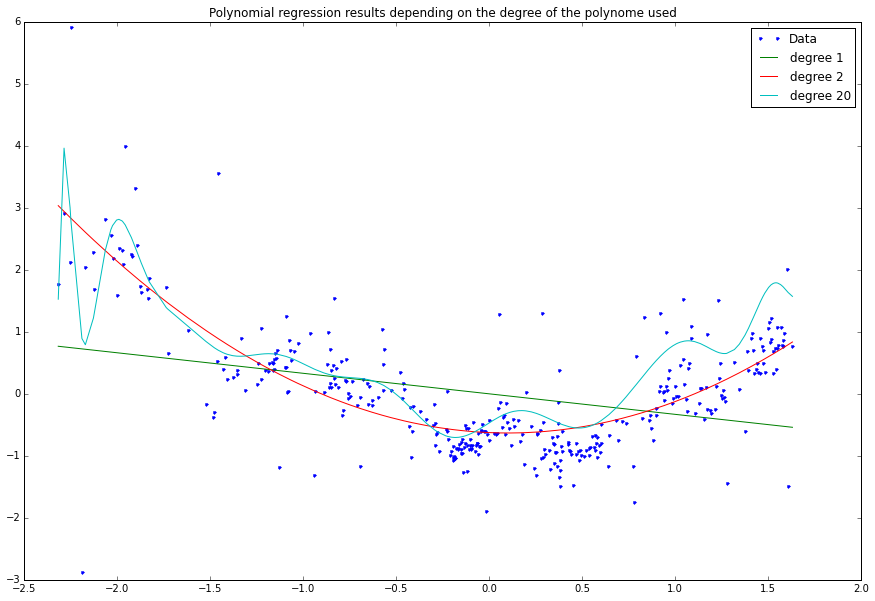

In [6]:
# Degrees to plot you can change these values to
# see how the degree of the polynom affects the 
# predicted function
degrees = [1, 2, 20]
legend = ['Data']

plt.plot(X, Y, '.')
for degree in degrees:
    Y_poly_reg = polynomial_regression(X, Y, degree)
    plt.plot(X, Y_poly_reg)
    legend.append('degree ' + str(degree))
    
plt.legend(legend)
plt.title('Polynomial regression results depending on the degree of the polynome used')

The linear case is still underfitting but now, we see that the polynom of degree 20 is too sensitive to the data, especially around $[-2.5, -1.5]$. This phenomena is called **overfitting**: the model starts fitting the noise as well.

## Regression with kernel gaussian

Lastly, we look at function of the type $f(x) = \sum \phi_i(x)$ with $\phi_i(x) = \exp({-\frac{x - b_i}{\sigma^2}}$). $b_i$ is called the base and $\sigma$ is its width.

Usually, the $b_i$ are taken randomly within the dataset. That is what I did in the implementation with b the number of bases.

In the plot, there is the base function used to compute the regressed function and the latter.

In [7]:
def gaussian_regression(X, Y, b, sigma, return_base=True):
    """b is the number of bases to use, sigma is the variance of the
    base functions."""
    
    # Building the Phi matrix
    Ones = np.ones((X.shape[0], 1))
    # Add a column of ones
    phi_X = np.hstack((Ones, X))
    
    # Choose randomly without replacement b values from X
    # to be the center of the base functions
    X_array = np.array(X).reshape(1, -1)[0]
    bases = np.random.choice(X_array, b, replace=False)
    
    bases_function = []
    for i in range(1, b):
        base_function = np.exp(-0.5 * (((X_array - bases[i - 1] * 
                                        np.ones(len(X_array))) / sigma) ** 2))
        bases_function.append(base_function)
        phi_X = np.hstack((phi_X, np.asmatrix(base_function).T))

    w = np.dot(np.dot(inv(np.dot(phi_X.T, phi_X)), phi_X.T), Y)

    if return_base:
        return np.dot(phi_X, w), bases_function
    else:
        return np.dot(phi_X, w)

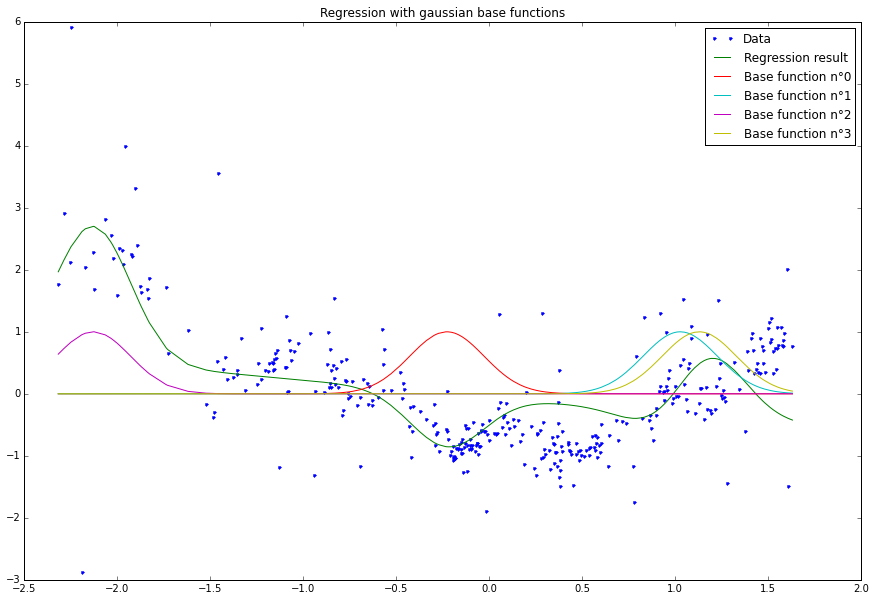

In [10]:
# By changing this value, you will change the width of the base functions
sigma = 0.2
# b is the number of base functions used
b = 5
Y_gauss_reg, bases_function = gaussian_regression(X, Y, b, sigma)

# Plotting the base functions and the dataset
plt.plot(X, Y, '.')
plt.plot(X, Y_gauss_reg)

legend = ['Data', 'Regression result']
for i, base_function in enumerate(bases_function):
    plt.plot(X, base_function)
    legend.append('Base function n°' + str(i))

plt.legend(legend)
plt.title('Regression with gaussian base functions')

We can observe that here the sigma is too small. Some part of the dataset are too far away from the bases to be taken into accoutn.
If you change the <code>sigma</code> in the code to 0.5 and then 1. You will notice how the output function will get closer to the data.